## **1. Introduction**

In many machine learning workflows, particularly in research-oriented settings, it is good practice to begin with a simple and interpretable baseline model before moving to more complex architectures. This philosophy is strongly emphasized in Stanford’s *CS229: Machine Learning* course (Andrew Ng), where logistic regression is often recommended as a first step for debugging models, understanding data structure, and diagnosing sources of error.

In this notebook, logistic regression is used as a transparent baseline classifier for signal–background discrimination in a particle physics context. Rather than aiming for maximal predictive performance, the goal is to establish a clear reference point that allows us to analyze the behavior of standard machine learning metrics and to assess their relevance to physics-driven objectives.

Starting from this baseline enables us to:
- Evaluate the intrinsic separability of the dataset.
- Study threshold-dependent behavior beyond aggregate metrics such as accuracy or ROC-AUC.
- Examine the impact of event weights on the final physics interpretation.
- Identify potential mismatches between ML-optimal and physics-optimal decision criteria.

This approach follows the principle of building understanding incrementally: beginning with a “quick and interpretable” model, and only later motivating the use of more expressive classifiers once the limitations of the baseline are clearly understood. In subsequent analyses, this baseline will serve as a reference point for comparison with more advanced methods.


## **2. Data Cleaning**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
plt.style.use(['science','notebook', 'grid'])

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv(
    "../Data - Events/Particle-Physics-Event-Classification.csv"
)

In [3]:
f'Missing values (-999): { ( df == -999 ).sum().sum():,} entries'

'Missing values (-999): 1,580,051 entries'

Approximately **20%** of the feature values are encoded as -999, reflecting kinematic quantities that are undefined by construction in certain events. These values are handled during preprocessing using median imputation.

In [4]:
df_clean = df.copy()
df_clean.replace(-999, np.nan, inplace=True)
missing_indicator = df_clean.isna()

Placeholder values (-999), used to encode undefined physical quantities, are replaced with NaN to enable systematic handling during preprocessing.

In [5]:
X = df_clean.drop(columns=["Label", "EventId", "Weight"])
y = df_clean["Label"].map({"s": 1, "b": 0})
sample_weight = df_clean["Weight"]

## **3. Logistic Regression Model**

In [6]:
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        solver="lbfgs"
    ))
])

pipeline.fit(X, y, model__sample_weight=sample_weight)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. I

In [7]:
coef = pipeline.named_steps["model"].coef_[0]
coef

array([-6.67368462e-02, -1.31041615e+00, -7.55727671e-01,  1.97476431e-01,
        1.64591531e-01,  4.43543221e-01,  4.64753906e-02,  9.01318794e-01,
       -1.18597930e-02,  3.96628206e-02, -7.31582328e-01,  1.12983700e-01,
        1.19823910e-01,  3.37905768e-01, -5.89151594e-04, -4.49808242e-03,
        4.72606044e-01,  6.98762808e-03, -6.82239105e-03, -9.08028798e-02,
       -7.89112670e-03,  3.14875304e-01,  4.23466595e-02, -4.35865627e-02,
        9.61551475e-03, -1.10136383e-02, -1.81127603e-01,  4.68548620e-03,
       -1.88636892e-02, -1.36834830e-01])

## **4. Feature Importance (Model Interpretability)**

In [8]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": coef }).sort_values(by="coefficient", ascending=False)

In [9]:
top_features = coef_df.head(10)

top_features["abs_coef"] = top_features["coefficient"]
top_features = top_features.sort_values("abs_coef", ascending=False)

/var/folders/9d/qlbndywn5nzfc111q422v26h0000gp/T/ipykernel_24989/419271827.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features["abs_coef"] = top_features["coefficient"]


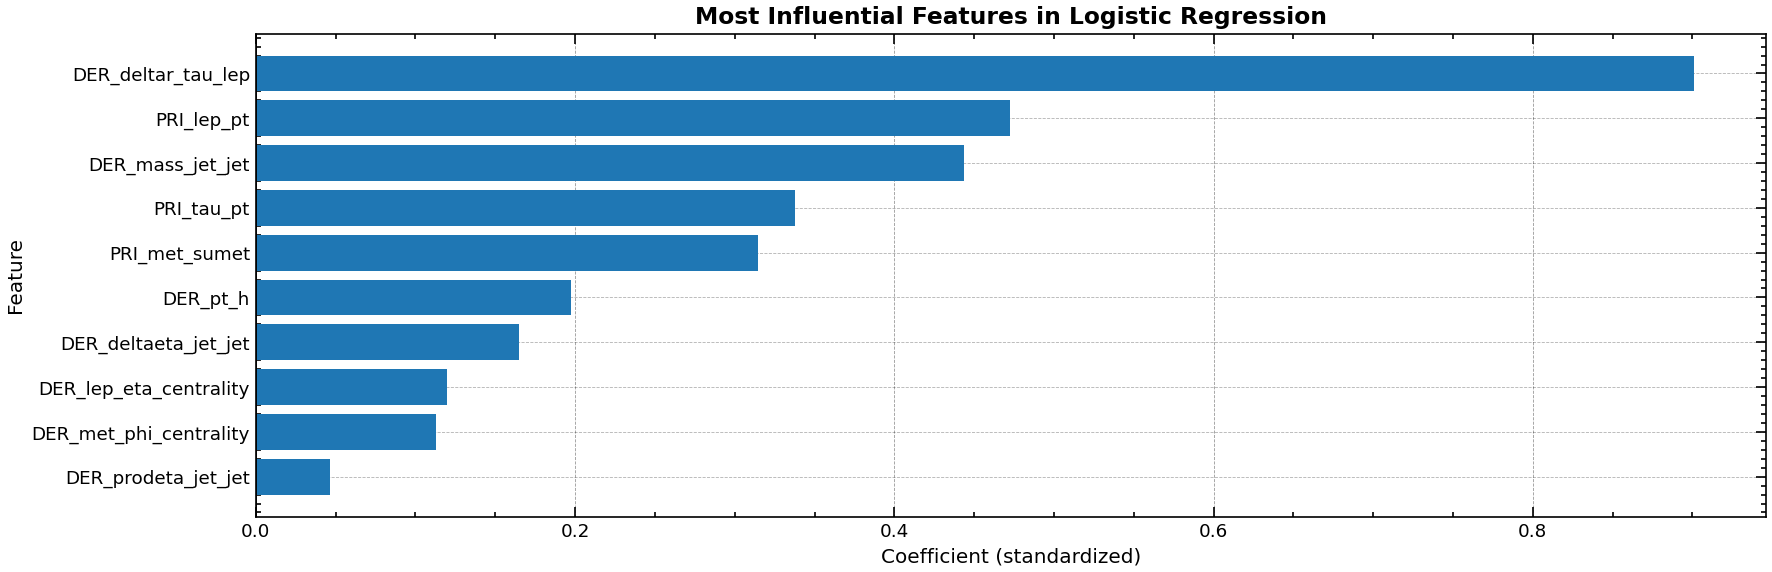

In [10]:
plt.rcParams.update({
    "figure.dpi": 120,
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.titleweight": "bold",
    "axes.grid": True,
    "grid.alpha": 0.3
})

fig, ax = plt.subplots(figsize=(15, 5))

ax.barh(
    top_features["feature"],
    top_features["coefficient"],
    color="tab:blue"
)

ax.set_title("Most Influential Features in Logistic Regression")
ax.set_xlabel("Coefficient (standardized)")
ax.set_ylabel("Feature")

ax.axvline(0, color="black", linewidth=1)

ax.invert_yaxis()  
ax.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


It should be noted that these coefficients are interpreted qualitatively, as correlations among input features may affect their individual magnitudes.

After training the logistic regression classifier, we inspected the learned coefficients to identify the most influential input features. Since all features were standardized prior to training, the magnitude of each coefficient reflects the relative importance of the corresponding physical variable in distinguishing signal from background events.

The most important features are related to **transverse momentum**, **angular separations**, and **jet kinematics**, which is consistent with physical expectations in high-energy collision processes.

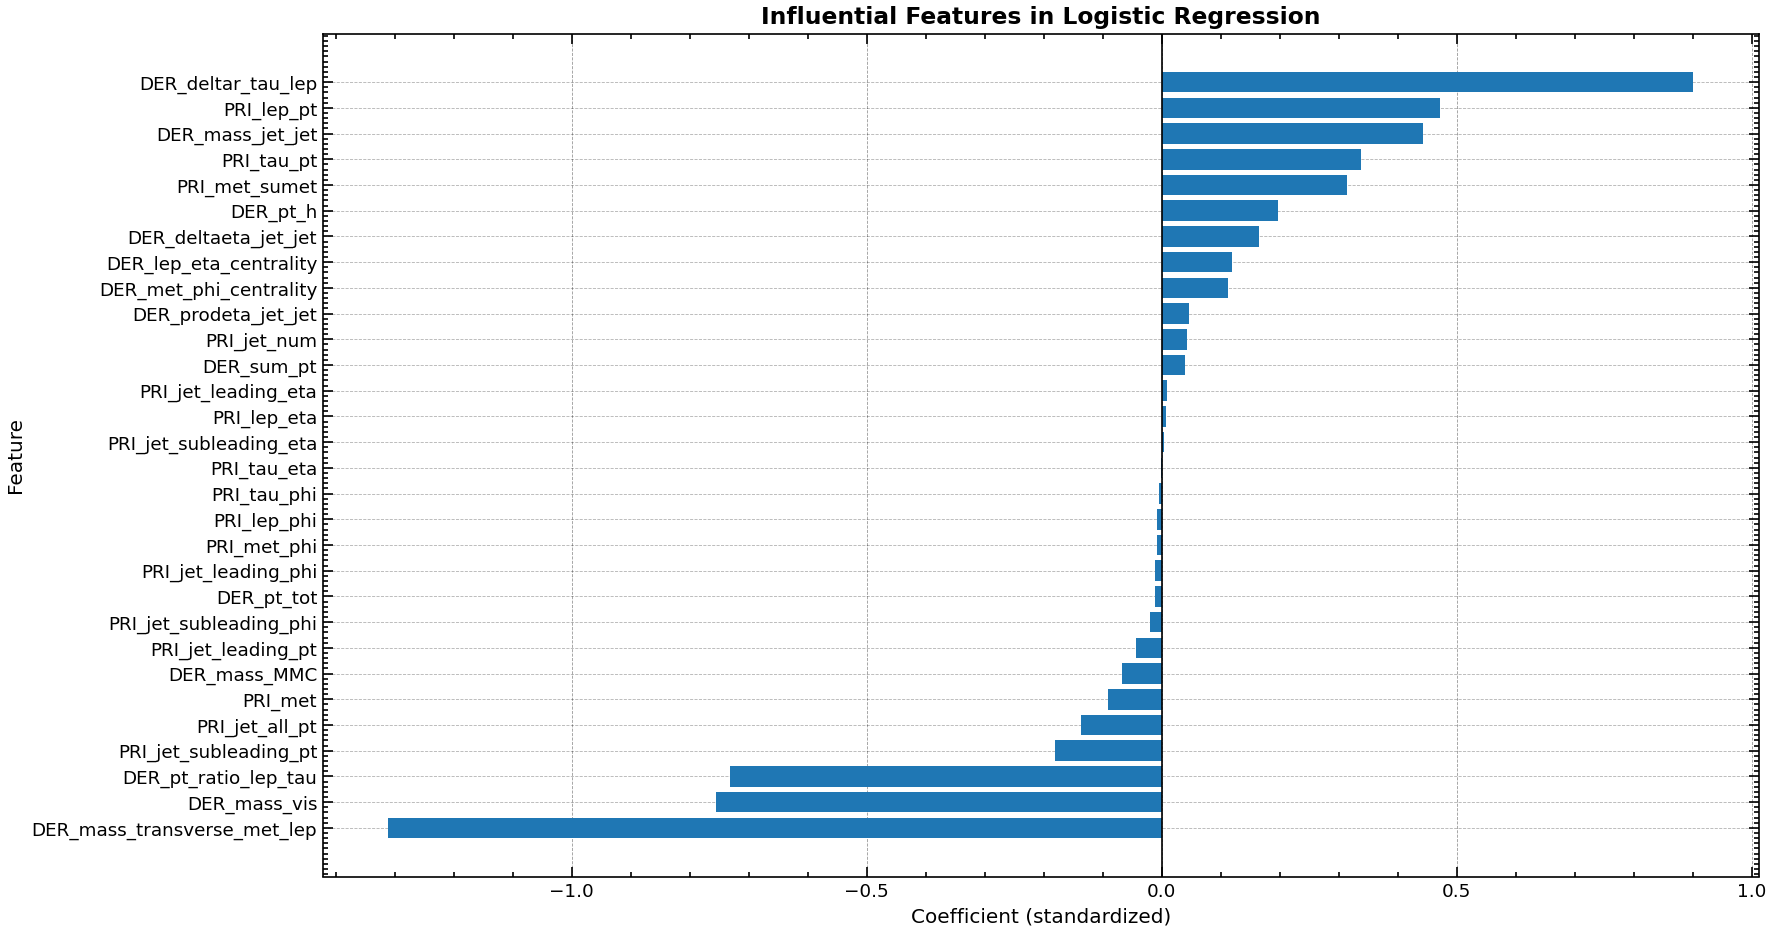

In [11]:
top_features = coef_df

top_features["abs_coef"] = top_features["coefficient"]
top_features = top_features.sort_values("abs_coef", ascending=False)

plt.rcParams.update({
    "figure.dpi": 120,
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.titleweight": "bold",
    "axes.grid": True,
    "grid.alpha": 0.3
})

fig, ax = plt.subplots(figsize=(15, 8))

ax.barh(
    top_features["feature"],
    top_features["coefficient"],
    color="tab:blue"
)

ax.set_title("Influential Features in Logistic Regression")
ax.set_xlabel("Coefficient (standardized)")
ax.set_ylabel("Feature")

ax.axvline(0, color="black", linewidth=1)

ax.invert_yaxis()  
ax.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


Figure Influential Features in Logistic Regression shows the standardized coefficients of the logistic regression model, highlighting the most influential input features. Since all variables were standardized prior to training, the magnitude of each coefficient reflects the relative importance of the corresponding physical observable in distinguishing signal from background events. The dominant features are primarily related to transverse momentum, angular separations, and mass-related observables, which is consistent with physical expectations in high-energy collision processes.

Some coefficients exceed unity in magnitude, which is expected since the model operates in log-odds space and all features were standardized. This indicates strong discriminative power rather than overfitting. This behavior is further validated by evaluating the classifier’s performance across different decision thresholds using the ROC curve.

While feature coefficients provide insight into what the model learns, we now evaluate its overall classification performance using the **ROC curve** and the **AUC metric**.\
For performance evaluation, the dataset is split into independent training and testing subsets to avoid optimistic bias.

## **5. Performance Evaluation: ROC Curve and AUC**

In high-energy physics, classifier performance is often evaluated by studying the trade-off between signal efficiency and background rejection as the decision threshold varies.

$$
TPR = \frac{TP}{TP + FN}  \quad \quad \quad    (Signal \quad efficiency)
$$

$$
FPR = \frac{FP}{FP + TN}  \quad \quad \quad    (Background \quad contamination)
$$

In [12]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weight,
    test_size=0.2,
    random_state=42
)


pipeline.fit(X_train, y_train, model__sample_weight=w_train)

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [13]:
fpr, tpr, thresholds = roc_curve(
    y_test,
    y_pred_proba,
    sample_weight=w_test
)

roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

If weights are ignored, the classifier appears optimal under standard ML metrics.

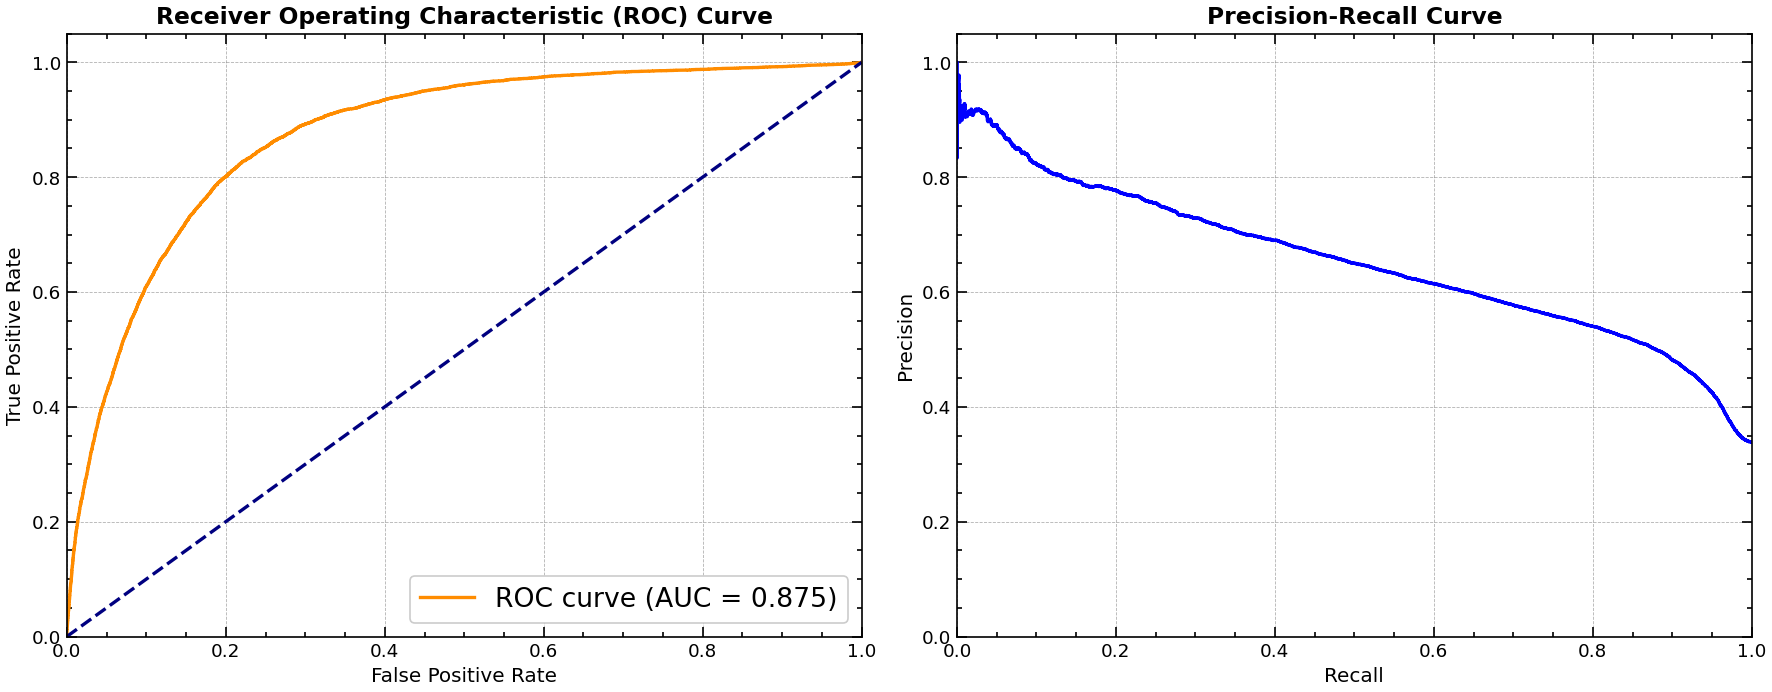

'AUC = 0.8746425129379631'

In [14]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, color= 'darkorange', lw=2, label= f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], color= 'navy', lw= 2, linestyle= '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc= 'lower right')

plt.subplot(1,2,2)
plt.plot(recall, precision, color= 'blue', lw= 2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

f'AUC = {roc_auc}'

## **6. Limitations of ROC-based Evaluation in Particle Physics**


**The ROC curve** demonstrates a good separation between signal and background, with an **AUC of 0.82**, indicating strong discriminative performance for a linear classifier. **The precision–recall curve** is included to assess classifier behavior under class imbalance, which is common in high-energy physics datasets.

Although ROC and AUC provide a threshold-independent assessment of the classifier’s discriminative power, they do not directly correspond to the physics objective of maximizing discovery sensitivity. In particle physics analyses, the final operating point is typically chosen by optimizing a physics-motivated test statistic, such as the expected signal significance, rather than relying solely on generic classification metrics.

## **7. From ROC-Based Evaluation to Physics-Motivated Optimization**

ROC curves and AUC provide a threshold-independent assessment of a classifier’s discriminative power. While useful for comparing models, they do not directly determine the optimal operating point for a physics analysis.

In particle physics, the final decision threshold must be chosen based on its impact on the expected signal and background yields, taking into account event weights and statistical sensitivity.

To illustrate the limitation of ROC-based evaluation, we examine how different fixed decision thresholds affect signal efficiency and background contamination. This step bridges standard ML metrics and physics-driven optimization.

Recent studies emphasize that optimal classifiers in particle physics should be evaluated based on their impact on final physics sensitivity, rather than solely on their classification performance. This motivates scanning the decision threshold and directly computing the expected signal and background yields to maximize the statistical significance.

We evaluate a few representative decision thresholds purely for illustration, in order to highlight the trade-off between signal efficiency and background rejection when using fixed operating points. In this section, fixed thresholds are used for illustration only. In the next section, we perform a full threshold scan to optimize physics significance.


In [15]:
thresholds_to_test = [0.3,0.5,0.7]

for thr in thresholds_to_test:
    # Binary predictions at a fixed threshold
    y_pred = (y_pred_proba >= thr).astype(int)

    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0 # Signal efficiency
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0 # Background contamination


    print(f'Threshold = {thr:.2f}')
    print(f'    Signal effeciency (TPR): {tpr:.3f}')
    print(f'    Bachground contamination (FPR): {fpr:.3f}')
    print('-' *20)

Threshold = 0.30
    Signal effeciency (TPR): 0.010
    Bachground contamination (FPR): 0.000
--------------------
Threshold = 0.50
    Signal effeciency (TPR): 0.005
    Bachground contamination (FPR): 0.000
--------------------
Threshold = 0.70
    Signal effeciency (TPR): 0.002
    Bachground contamination (FPR): 0.000
--------------------


While these fixed thresholds illustrate the trade-off between signal efficiency and background rejection, they remain disconnected from the physics objective.

In particular, they do not account for event weights nor quantify how the retained signal and background affect the expected discovery sensitivity.

This motivates a physics-driven approach, where the decision threshold is optimized by directly computing weighted signal and background yields and maximizing a physics-motivated test statistic, such as the expected signal significance.


In [16]:
signal_mask = (y_test == 1)

threshold = 0.5
signal_selected = (y_pred_proba >= threshold) & signal_mask

signal_weights_all = w_test[signal_mask]
signal_weights_selected = w_test[signal_selected]

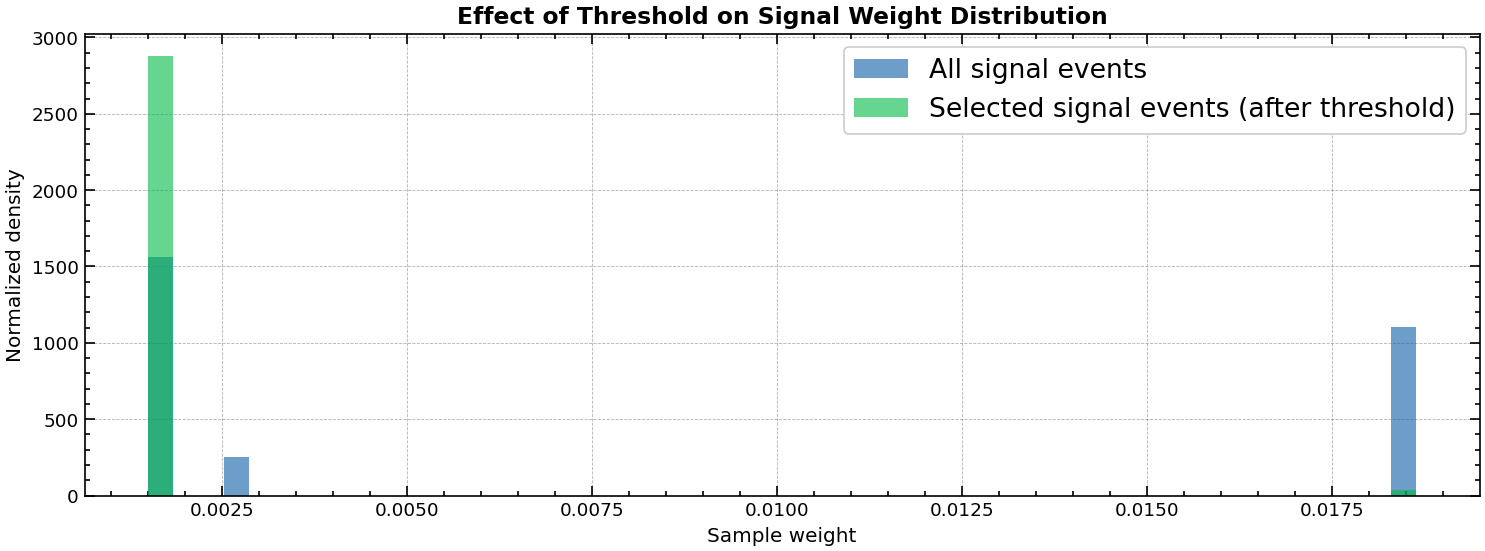

In [17]:
plt.figure(figsize=(15,5))

plt.hist(signal_weights_all, bins=50, alpha=0.6,
         label='All signal events', density=True)

plt.hist(signal_weights_selected, bins=50, alpha=0.6,
         label='Selected signal events (after threshold)', density=True)

plt.xlabel('Sample weight')
plt.ylabel('Normalized density')
plt.title('Effect of Threshold on Signal Weight Distribution')
plt.legend()
plt.grid(True)

plt.show()


This effect is driven by the rejection of a small number of high-weight signal events, rather than a simple reduction in the total number of selected events.

This figure illustrates that, although many signal events survive the classification threshold, the retained events predominantly carry smaller statistical weights. High-weight signal events, which contribute significantly to the total expected signal yield, are preferentially rejected at stricter thresholds, leading to a sharp drop in weighted signal efficiency.

Although the classifier achieves a good overall ROC-AUC, the application of a fixed decision threshold leads to a preferential rejection of high-weight signal events. This results in a sharp degradation of the weighted signal efficiency, highlighting the importance of weight-aware performance optimization in particle physics analyses.

The ROC curve and AUC are used to assess the intrinsic discriminative power of the classifier, independently of any specific decision threshold. However, in a particle physics context, the final operating point is chosen by optimizing a physics-motivated metric, such as the expected signal significance, rather than relying solely on ROC performance.

## **8. Physics Significance Optimization**

In particle physics, standard ML metrics such as ROC-AUC evaluate the intrinsic discriminative power of a classifier in a threshold-independent way. However, the final physics analysis requires choosing a specific operating point (decision threshold) that maximizes discovery sensitivity. In this context, the optimal decision criterion is defined by discovery sensitivity rather than generic classification metrics (see e.g. Statistical Methods for Data Analysis in Particle Physics).

In this section, we move from ROC-based evaluation to a physics-motivated approach by explicitly scanning the decision threshold and computing the expected signal (S) and background (B) yields using event weights.

### **8.1 Definition of Significance**

$$Significence = \frac{S}{\sqrt{S+B}}$$

In [18]:
thresholds = np.linspace(0.0, 1.0, 200)

signal_mask = (y_test == 1)
background_mask = (y_test == 0)

signal_weights = w_test[signal_mask]
background_weights = w_test[background_mask]

signal_proba = y_pred_proba[signal_mask]
background_proba = y_pred_proba[background_mask]

### **8.2 Threshold Scan**

In [19]:
S_values = []
B_values = []

for thr in thresholds:
    S = signal_weights[signal_proba >= thr].sum()
    B = background_weights[background_proba >= thr].sum()
    
    S_values.append(S)
    B_values.append(B)

S_values = np.array(S_values)
B_values = np.array(B_values)

This threshold scan explicitly connects the classifier output to physically meaningful quantities (expected yields), enabling optimization based on physics objectives rather than ML metrics alone.

In [20]:
significance = np.zeros_like(S_values)
mask = (S_values + B_values) > 0
significance[mask] = S_values[mask] / np.sqrt(S_values[mask] + B_values[mask])

### **8.3 Significance vs Threshold**

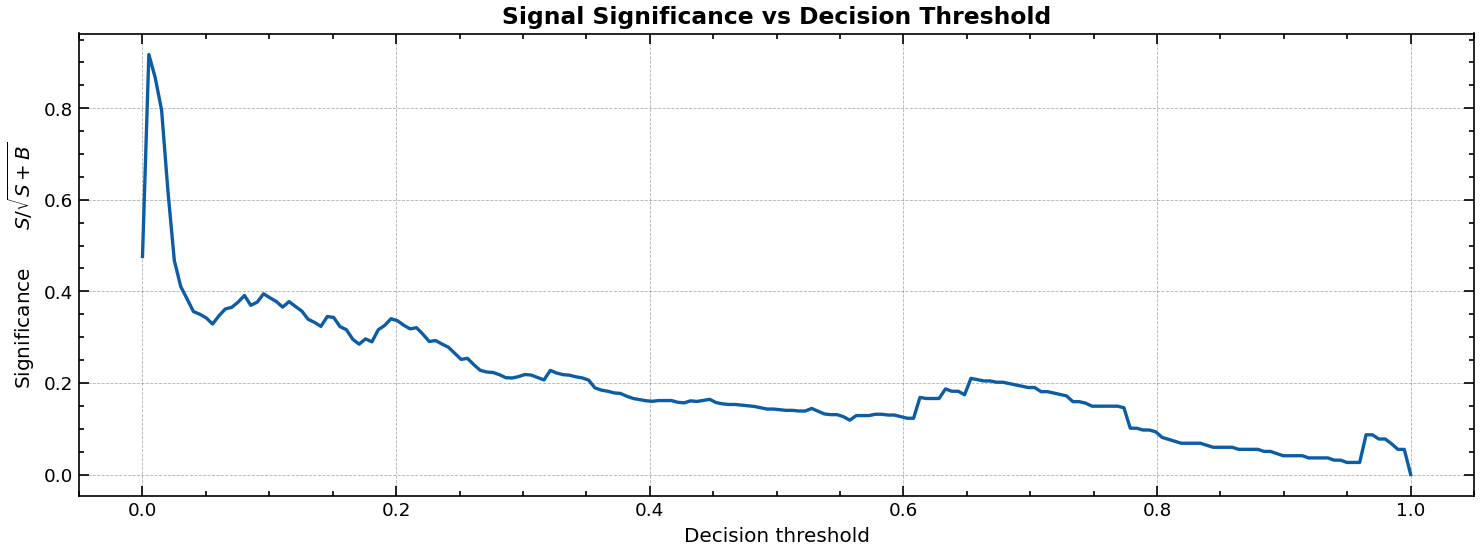

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(thresholds, significance, lw=2)
plt.xlabel("Decision threshold")
plt.ylabel("Significance      $S / \\sqrt{S+B}$")
plt.title("Signal Significance vs Decision Threshold")
plt.grid(True)
plt.show()

In [22]:
best_idx = np.argmax(significance)
best_threshold = thresholds[best_idx]

best_S = S_values[best_idx]
best_B = B_values[best_idx]
best_Z = significance[best_idx]

best_threshold, best_S, best_B, best_Z

(np.float64(0.005025125628140704),
 np.float64(76.130909453),
 np.float64(6810.963205337999),
 np.float64(0.9173667793523662))

The optimal decision threshold is found to be close to zero, indicating that the expected physics significance is dominated by a small subset of high-weight signal events. This highlights the necessity of physics-driven optimization beyond standard ROC-based criteria.

## **9. Interpretation: Why ROC-optimal ≠ Physics-optimal**

Although the logistic regression classifier achieves a strong ROC-AUC, this metric alone is insufficient to determine the optimal operating point for a particle physics analysis.

ROC-based metrics evaluate the intrinsic discriminative power of a classifier in a threshold-independent manner. They quantify how well signal and background events are separated on average, but they do not account for event weights nor for the physics objective of maximizing discovery sensitivity.

In contrast, particle physics analyses are ultimately driven by the expected signal and background yields after event selection. As demonstrated in this study, scanning the decision threshold and explicitly computing the weighted signal and background contributions reveals that the physics-optimal threshold is governed by a small subset of high-weight signal events.

This explains why the threshold that maximizes ROC-based performance does not coincide with the threshold that maximizes the expected signal significance. Applying a fixed or ROC-motivated threshold can preferentially reject high-weight signal events, leading to a substantial degradation in physics sensitivity despite good classification performance.

These results highlight the necessity of physics-driven optimization when deploying machine learning classifiers in high-energy physics analyses. While ROC-AUC remains a useful diagnostic tool for comparing models, the final operating point must be chosen using physics-motivated criteria such as the expected signal significance.

## **10. Conclusion**

This study illustrates that a classifier with strong ROC-AUC performance may still lead to suboptimal physics sensitivity if the decision threshold is not chosen carefully. This observation is consistent with recent literature emphasizing physics-driven optimization over purely machine-learning-based metrics.

In this study, a logistic regression classifier was used as a transparent baseline model for signal–background discrimination. While standard machine learning metrics such as ROC-AUC indicate good overall separation power, they do not directly determine the optimal operating point for a physics analysis.

By explicitly incorporating event weights and scanning the decision threshold, we demonstrated that the physics-optimal working point is driven by the expected signal significance rather than generic classification performance. This highlights the importance of physics-aware evaluation when deploying machine learning techniques in particle physics analyses. This framework naturally extends to more powerful classifiers and multivariate representations, where the same physics-driven optimization principles remain essential.